# MLOPS ZOOMCAMP First Homework
### importing necessary libraries

In [6]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pandas as pd
import requests
from io import BytesIO

### Importing Data 

In [30]:

url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet'
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
response.raise_for_status()  # Will raise an HTTPError if the HTTP request returned an unsuccessful status code

file_obj = BytesIO(response.content)
df = pd.read_parquet(file_obj)
df.head()


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


### Calculating, Dropping outliers and calculating STD of Duration

In [31]:
row_number_before_cleaning = df.shape[0]
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
print(f"Standard Deviation ofduration before dropping outliers:{df['duration'].std()}")
df = df[(df.duration >= 1) & (df.duration <= 60)]
row_number_after_cleaning = df.shape[0]
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)


Standard Deviation ofduration before dropping outliers:59.33859413164492


In [49]:
# fraction of the records left after you dropped the outliers?
fraction = 1 - (row_number_before_cleaning - row_number_after_cleaning)/row_number_before_cleaning 
print(f"Fraction records left after you dropped the outliers: {fraction}")

Fraction records left after you dropped the outliers: 0.9658903787344154


###  One-hot encoding and Get the feature from the matrix. 

In [50]:
#One-hot encoding
df[['PULocationID', 'DOLocationID']] = df[['PULocationID', 'DOLocationID']].astype(str)  
dv = DictVectorizer()
train_dicts = df[['PULocationID', 'DOLocationID']].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts) 
dimension = X_train.shape[1]
print(f"Dimensionality of matrix : {dimension}")

Dimensionality of matrix : 506


### Training Model and Calculating RMSE

In [56]:
target = 'duration'
y_train = df[target].values
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
RMSE = mean_squared_error(y_train, y_pred, squared=False)


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [57]:
print(f"RMSE for training: {RMSE}")

RMSE for training: 9.775596030350558


### Evaluation Model using Data of  February 

In [63]:
#Februery data
df_val = pd.read_parquet ('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')
# Dropping Outliers
df_val['duration'] = df_val.lpep_dropoff_datetime - df_val.lpep_pickup_datetime
df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]

df_val[['PULocationID', 'DOLocationID']] = df_val[['PULocationID', 'DOLocationID']].astype(str)  
validation_dicts = df_val[['PULocationID', 'DOLocationID']].to_dict(orient='records')
X_validation = dv.transform(validation_dicts)

y_validation = df_val['duration'].values
y_prediction = model.predict(X_validation)
RMSE_val = mean_squared_error(y_validation, y_prediction, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [65]:
print(f"RMSE for validation: {RMSE_val}")

RMSE for validation: 10.47374078395775


/tmp/ipykernel_1894/1505421196.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_1894/1505421196.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


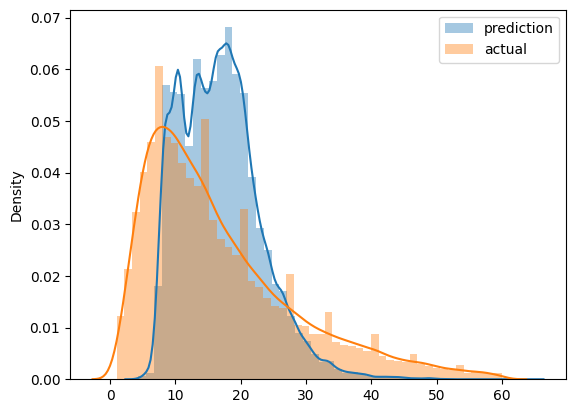

In [66]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()